# Investigation of compression for LOW data

Baseline dependent averaging is a form of data compression. In this script, we use a gridded approach to BDA. We create a critically sampled snapshot of a LOW data set, and then compress and decompress it to see what errors result.

In [1]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility, vis_summary
from arl.skymodel.operations import create_skycomponent, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, create_image_from_array, reproject_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.compress import compress_visibility, decompress_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image
from arl.fourier_transforms.ftprocessor import *

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the configuration and fill in the appropriate sampling values

In [2]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=2048
else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    
nsnapshots = 100
oversampling = 4

sampling_time = 35.0 / (oversampling * b)
log.info("Critical sampling time = %.5f (radians) %.2f (seconds)" % 
         (sampling_time, sampling_time * 43200.0 / numpy.pi))
sampling_frequency = 1e8 * 35.0 / (oversampling * b) 
log.info("Critical sampling frequency = %.5f (Hz) " % (sampling_frequency))
times = numpy.arange(0.0, + nsnapshots * sampling_time, sampling_time)
frequency = numpy.linspace(1e8 - sampling_frequency, 1e8 + sampling_frequency, 3)
frequency = numpy.array([1e8])

log.info("Observing frequencies %s Hz" % (frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

Critical sampling time = 0.00219 (radians) 30.08 (seconds)
Critical sampling frequency = 218750.00000 (Hz) 
Observing frequencies [  1.00000000e+08] Hz
Cellsize = 0.001000 radians


We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [3]:
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: Visibility: 1369500 rows, 1.408 GB


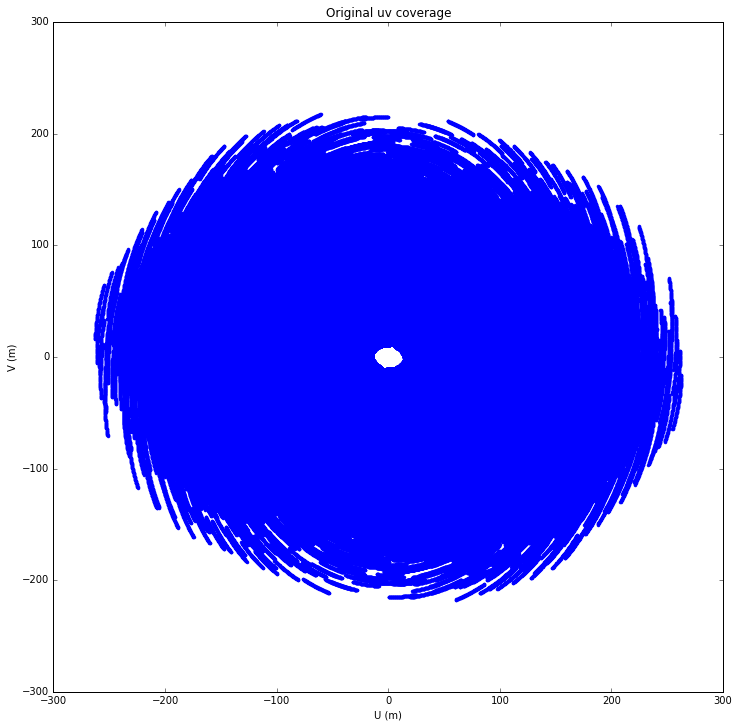

In [4]:
plt.clf()
for chan in range(len(vt.frequency)):
    plt.plot(+vt.uvw_lambda(chan)[:,0], +vt.uvw_lambda(chan)[:,1], '.', color='b')
    plt.plot(-vt.uvw_lambda(chan)[:,0], -vt.uvw_lambda(chan)[:,1], '.', color='b')
plt.title('Original uv coverage')
plt.xlabel('U (m)')
plt.ylabel('V (m)')
plt.show()

Create the standard LOW test image and predict the visibilities

In [5]:
vt.data['vis'] *= 0.0
vt.data['uvw'][:,2] = 0


modeltype = "S3"
if modeltype == "S3":
    model = create_low_test_image(npixel=npixel, cellsize=cellsize/10.0)
    model.wcs.wcs.cdelt[0] *= 10.0
    model.wcs.wcs.cdelt[1] *= 10.0

    model.data[model.data>10]=0.0
else:
    
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, npol=1, nchan=1)
    centre = model.wcs.wcs.crpix-1
    spacing_pixels = npixel // 8
    log.info('Spacing in pixels = %s' % spacing_pixels)
    spacing = model.wcs.wcs.cdelt * spacing_pixels
    locations = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
    locations = [-2.5]


    original_comps = []
    # We calculate the source positions in pixels and then calculate the
    # world coordinates to put in the skycomponent description
    for iy in locations:
        for ix in locations:
            if ix >= iy:
                p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                    int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
                sc = pixel_to_skycoord(p[0], p[1], model.wcs)
                log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
                flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
                comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
                original_comps.append(comp)
                insert_skycomponent(model, comp)

create_image_from_array: created image of shape (1, 1, 512, 512), size 0.002 (GB)
create_low_test_image: 5111 sources inside the image
create_low_test_image: flux in S3 model = 1258.741, actual flux in image = 106.860


create_image_from_array: created image of shape (512, 512), size 0.002 (GB)


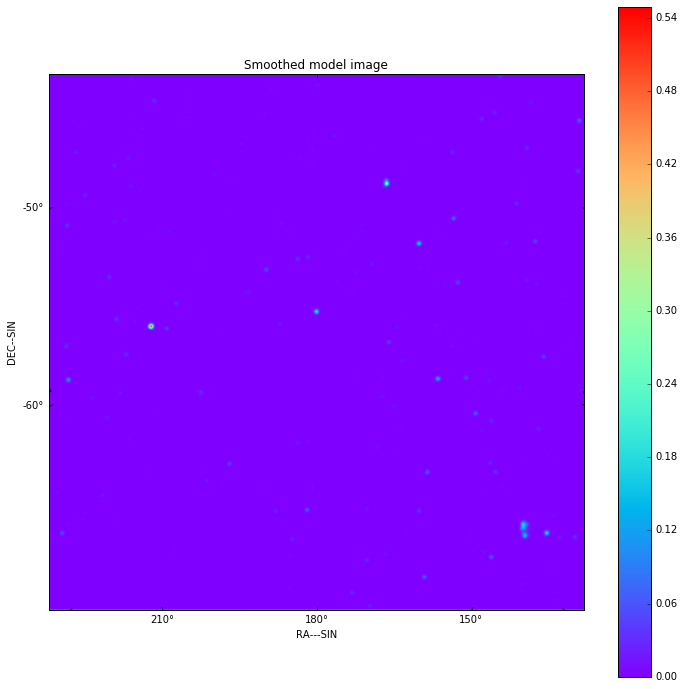

In [6]:
cmodel = create_image_from_array(convolve(model.data[0,0,:,:], Gaussian2DKernel(1.5), normalize_kernel=True), 
                                 model.wcs)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Fill in with the visibility of the model

In [7]:
vt = predict_2d(vt, model)

predict_2d: predict using 2d transform
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode


Compress and plot the uv coverage

compress_tbgrid_vis: Compressing 100 unique times and 27722 baselines
compress_tbgrid_vis: Time step between integrations seems to be 30.08 (seconds)
compress_visibility: Created new Visibility for compressed data, compression factor = 4.000
compress_visibility: Compressed 1369500 visibility rows (1 channels) into 169673 rows (1 channels)
compress_visibility: Original Visibility: 1369500 rows, 1.408 GB, compressed Visibility: 169673 rows, 0.174 GB


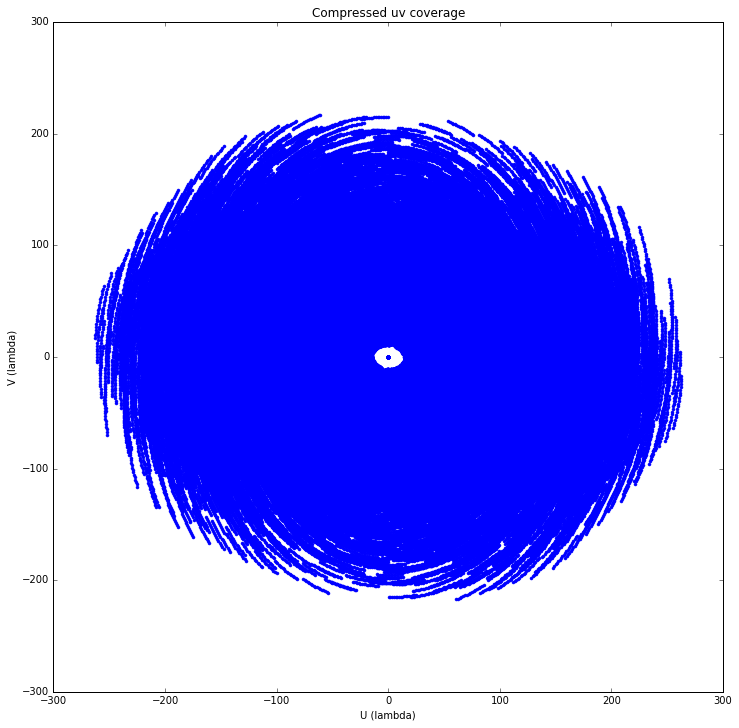

In [8]:
cvt, cindex = compress_visibility(vt, compression='tb', compression_factor=4.0, max_compression=10)
plt.clf()
for chan in range(len(cvt.frequency)):
    plt.plot(+cvt.uvw_lambda(chan)[:,0],+cvt.uvw_lambda(chan)[:,1], '.', color='b')
    plt.plot(-cvt.uvw_lambda(chan)[:,0],-cvt.uvw_lambda(chan)[:,1], '.', color='b')
plt.title('Compressed uv coverage')
plt.xlabel('U (lambda)')
plt.ylabel('V (lambda)')
plt.show()

Make the dirty images from original and compress data

invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
create_image_from_array: created image of shape (1, 1, 512, 512), size 0.002 (GB)


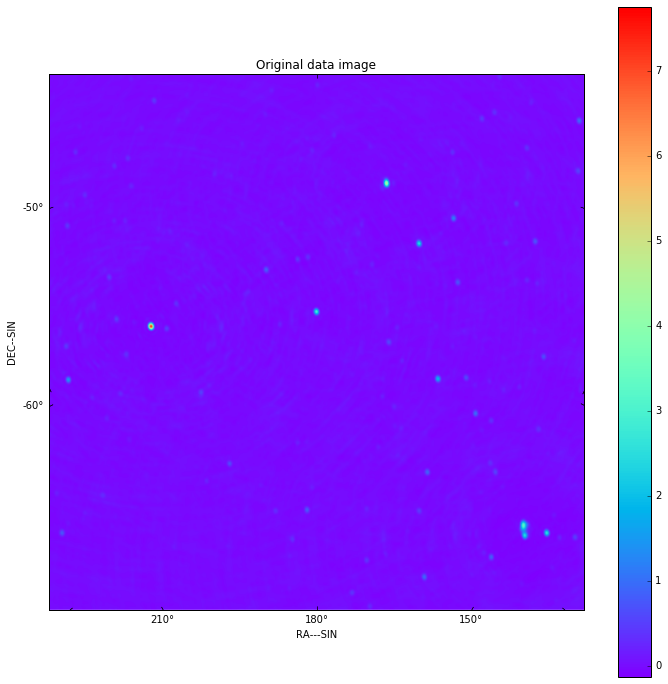

invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
create_image_from_array: created image of shape (1, 1, 512, 512), size 0.002 (GB)


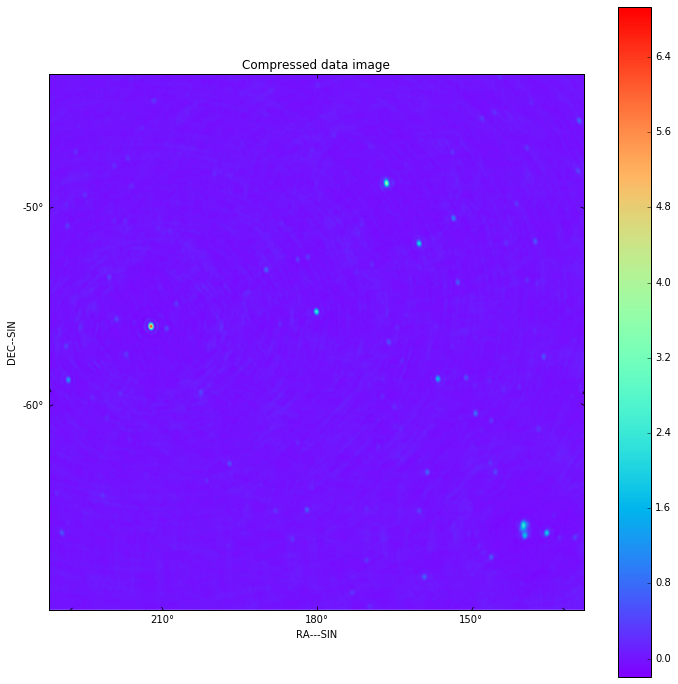

In [9]:
dirtyimage, sumwt = invert_2d(vt, model)
dirtyimage=normalize_sumwt(dirtyimage, sumwt)
show_image(dirtyimage)
plt.title('Original data image')
plt.show()

cdirtyimage, csumwt=invert_2d(cvt, model)
cdirtyimage=normalize_sumwt(cdirtyimage, csumwt)
show_image(cdirtyimage)
plt.title('Compressed data image')
plt.show()

Decompress and make the dirty image

decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 169673 visibility rows (1 channels) into 1369500 rows (1 channels)
compress_visibility: Original Visibility: 169673 rows, 0.174 GB, decompressed Visibility: 1369500 rows, 1.408 GB
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
create_image_from_array: created image of shape (1, 1, 512, 512), size 0.002 (GB)


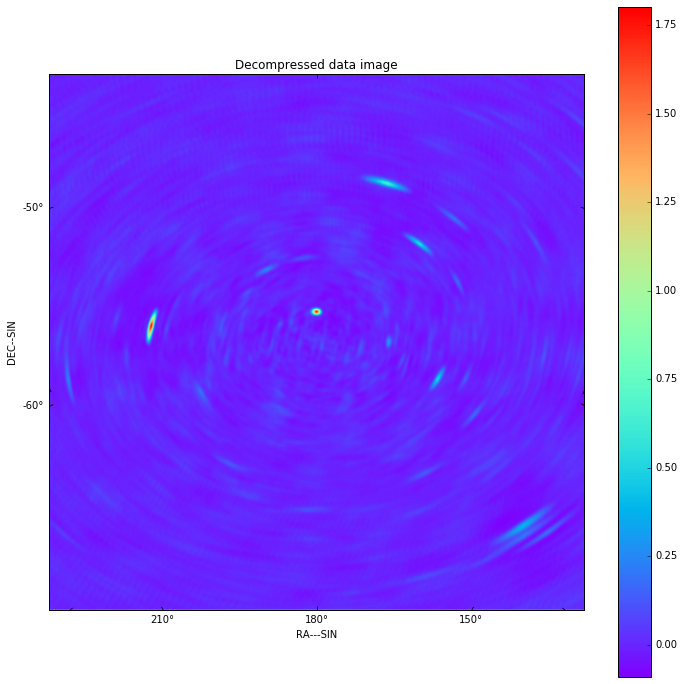

In [10]:
dcvt = decompress_visibility(cvt, vt, cindex=cindex, compression='tb')

dcdirtyimage, dcsumwt=invert_2d(dcvt, model)
dcdirtyimage=normalize_sumwt(dcdirtyimage, dcsumwt)
show_image(dcdirtyimage)
plt.title('Decompressed data image')
plt.show()

Now do a range of compression factors to see how the recovery error varies. We compress and decompress and difference the images

invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
create_image_from_array: created image of shape (1, 1, 512, 512), size 0.002 (GB)


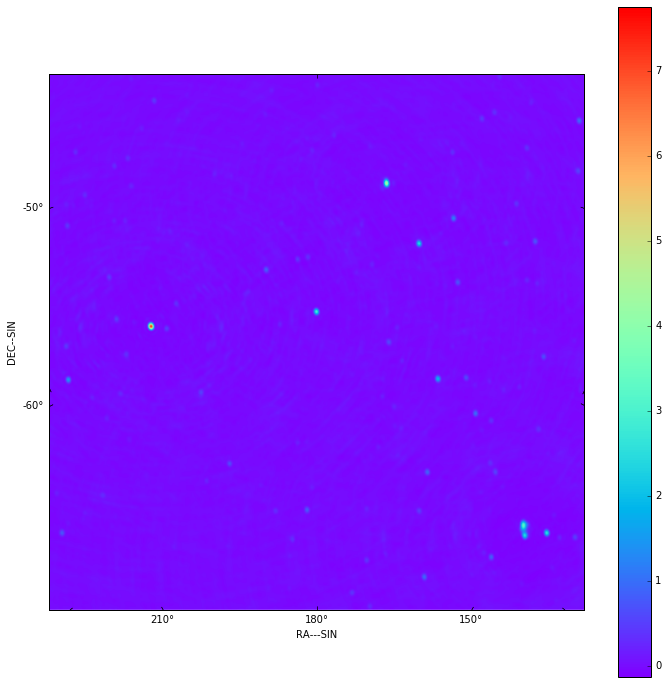

Original image Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		min: -0.127773638648
		median: -0.00599106919436
		shape: (1, 1, 512, 512)
		sum: 42.154968156
		rms: 0.0864655379355
		medianabs: 0.0228471081381
		max: 7.74869626897

compress_tbgrid_vis: Compressing 100 unique times and 27722 baselines
compress_tbgrid_vis: Time step between integrations seems to be 30.08 (seconds)
compress_visibility: Created new Visibility for compressed data, compression factor = 4.000
compress_visibility: Compressed 1369500 visibility rows (1 channels) into 140755 rows (1 channels)
compress_visibility: Original Visibility: 1369500 rows, 1.408 GB, compressed Visibility: 140755 rows, 0.145 GB
Compression using compression_factor = 4.000 took 19.8 seconds
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 140755 visibility rows (1 channels) into 1369500 rows (1 channels)
compress_visibility: Original Visibility: 140755 rows, 0.145 GB, decomp

In [11]:
dirtyimage, sumwt = invert_2d(vt, model)
dirtyimage=normalize_sumwt(dirtyimage, sumwt)
show_image(dirtyimage)
plt.show()

qa = qa_image(dirtyimage)
print("Original image", qa)

template_vis = copy.deepcopy(vt)

signal = []
error_peak = []
error_medianabs = []
t_invert = []
t_compresses = []
t_decompresses = []

compression_factors = [4.0, 2.0, 1.0, 0.5, 0.25]

for compression_factor in compression_factors:
    ts = clock()
    cvt, cindex = compress_visibility(vt, compression='tb', compression_factor=compression_factor, max_compression=100)
    t_compress = clock() - ts
    t_compresses.append(t_compress)
    log.debug("Compression using compression_factor = %.3f took %.1f seconds" % (compression_factor, t_compress))

    template_vis.data['vis']*=0.0
    ts = clock()
    dcvt = dcvt = decompress_visibility(cvt, vt, cindex=cindex, compression='tb')
    t_decompress = clock() - ts
    t_decompresses.append(t_decompress)
    log.debug("Decompression took %.1f seconds" % (t_decompress))
    
    ts = clock()
    dcdirtyimage, dcsumwt=invert_2d(dcvt, model)
    dcdirtyimage=normalize_sumwt(dcdirtyimage, dcsumwt)
    t_invert.append(clock() - ts)

    dcdirtyimage.data -= dirtyimage.data
    
    dcqa = qa_image(dcdirtyimage)
    print("Decompressed compressed image", dcqa)
    signal.append(qa.data['max'])
    error_peak.append(dcqa.data['max'])
    error_medianabs.append(dcqa.data['medianabs'])

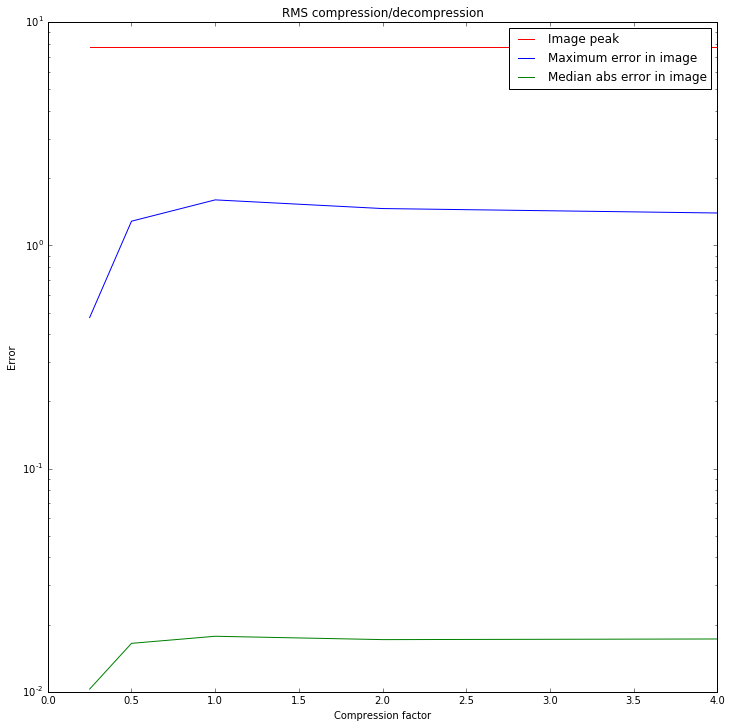

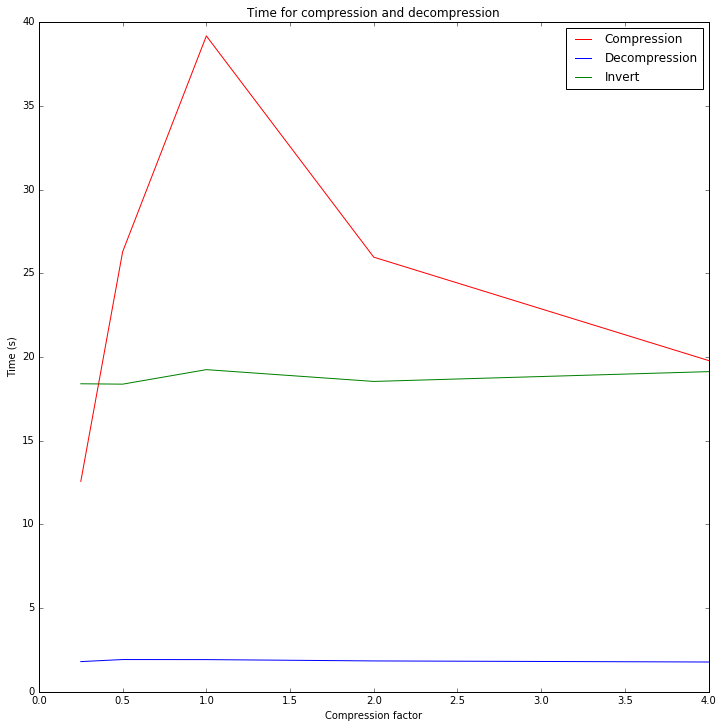

In [12]:
plt.clf()
plt.semilogy(compression_factors, signal, color='r', label='Image peak')
plt.semilogy(compression_factors, error_peak, color='b', label='Maximum error in image')
plt.semilogy(compression_factors, error_medianabs, color='g', label='Median abs error in image')
plt.title('RMS compression/decompression')
plt.xlabel('Compression factor')
plt.ylabel('Error')
plt.legend()
plt.show()
plt.plot(compression_factors, t_compresses, color='r', label='Compression')
plt.plot(compression_factors, t_decompresses, color='b', label='Decompression')
plt.plot(compression_factors, t_invert, color='g', label='Invert')

plt.legend()
plt.title('Time for compression and decompression')
plt.xlabel('Compression factor')
plt.ylabel('Time (s)')

plt.show()

